In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense, BatchNormalization, Dropout, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Conv2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import LearningRateScheduler
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In [29]:
model = Sequential()

# convo and pooling layers
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

# Freeze the weights of the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers on top of the base model
# x = Conv2D(128, (3, 3), activation='relu')(base_model.output)
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(units=7, activation='softmax')(x)

# Create the final model
model = Model(base_model.input, x)

In [19]:
# Adding a learning rate scheduler

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.9
    return lr

In [30]:
model.compile(optimizer=Adam(learning_rate=0.001), loss= categorical_crossentropy , metrics=['accuracy']  )

In [31]:
train_datagen = ImageDataGenerator(
     rotation_range=20,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest',
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "../MobileNet/archive/images/train/",
                                               target_size=(224,224),
                                               batch_size=20,
                                  )


train_data.class_indices

Found 28821 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [32]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "../MobileNet/archive/images/validation/",
                                           target_size=(224,224),
                                           batch_size=20,
                                  )


Found 7066 images belonging to 7 classes.


In [33]:
## having early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 15, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

#learning_ rate checker
lr = LearningRateScheduler(lr_scheduler) 

# puting call back in a list
call_back = [es, mc, lr]

In [36]:
hist = model.fit(train_data,
                steps_per_epoch= 100,
                epochs= 50,
                validation_data= val_data,
                validation_steps= 8,
                callbacks=call_back)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 2.2645 - accuracy: 0.2370
Epoch 1: val_accuracy improved from -inf to 0.34375, saving model to best_model.h5
100/100 [==============================] - 31s 289ms/step - loss: 2.2645 - accuracy: 0.2370 - val_loss: 1.8979 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.9590 - accuracy: 0.3055
Epoch 2: val_accuracy improved from 0.34375 to 0.45625, saving model to best_model.h5
100/100 [==============================] - 28s 282ms/step - loss: 1.9590 - accuracy: 0.3055 - val_loss: 1.4914 - val_accuracy: 0.4563 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 1.8321 - accuracy: 0.3445
Epoch 3: val_accuracy did not improve from 0.45625
100/100 [==============================] - 28s 279ms/step - loss: 1.8321 - accuracy: 0.3445 - val_loss: 1.7048 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 4/50
100/100 [==============================]

In [37]:
# Loading the best fit model
from keras.models import load_model
model = load_model("../MobileNet/best_model.h5")


In [38]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

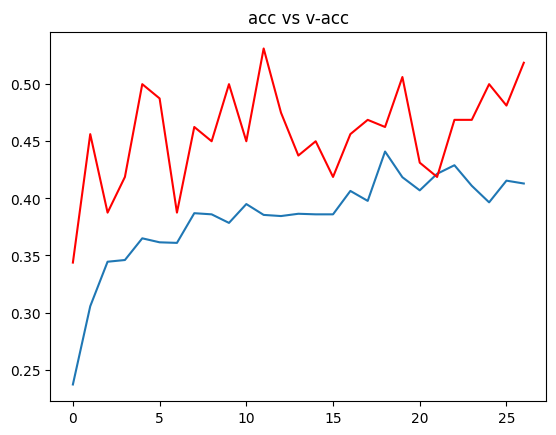

In [39]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

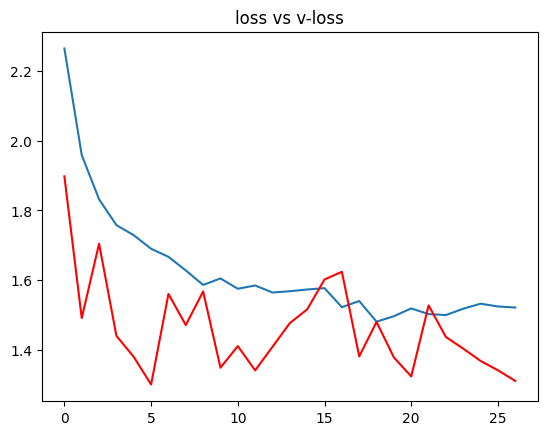

In [40]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [41]:

# just to map o/p values
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 36ms/step
 the image is of neutral


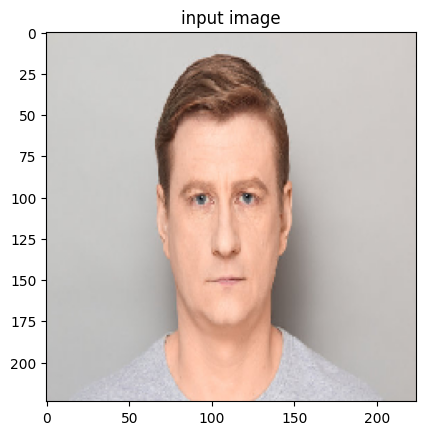

In [47]:
# path for the image to see if it predics correct class

path = "C:/Users/sahad/Desktop/Test/Neutral/360_F_342851651_BV9SYWnoTPSu3kq6e82zG7H8eEt20wd1.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()